# FISTA vs. Newton

FISTA is a popular algorithm to fit group-lasso and used in many existing packages.
We have an alternative approach using a Newton method to solve for the root of a convex function. This notebook studies the accuracy and speed differences between the two.

In [11]:
library(glstudy)
library(microbenchmark)
library(ggplot2)
library(reshape2)

In [52]:
check.acc <- function(beta, L, v, l1, l2)
{
    beta - (1./(L + l2 + l1 / sqrt(sum(beta**2)))) * v
}

bench <- function(ps, l1=1, l2=0, max.iters=as.integer(1e5), eval.max=100, seed=0) 
{
    times <- matrix(0, length(ps), 2)
    iters <- matrix(0, length(ps), 2)
    beta.newt <- list()
    beta.fista <- list()
    acc <- matrix(0, length(ps), 2)

    colnames(times) <- c('Newton', 'FISTA')
    colnames(iters) <- c('Newton', 'FISTA')
    colnames(acc) <- c('Newton', 'FISTA')

    for (i in 1:length(ps)) {
        set.seed(seed + i)
        p <- ps[i]
        L <- runif(p, 0, eval.max)
        v <- rnorm(p)

        bench.newt <- microbenchmark(
           {
            out.newt <- newton_solver(L, v, l1, l2, tol=1e-8, max_iters=max.iters)
           },
           unit='ns',
           times=10
        )
        times[i, 1] <- summary(bench.newt)$mean * 1e-9
        iters[i, 1] <- out.newt$iters
        beta.newt[[i]] <- out.newt$beta
        acc[i, 1] <- max(check.acc(out.newt$beta, L, v, l1, l2))
        
        bench.fista <- microbenchmark(
            {
                out.fista <- fista_solver(L, v, l1, l2, tol=1e-8, max_iters=max.iters)
            },
            unit='ns',
            times=10
        )
        times[i, 2] <- summary(bench.fista)$mean * 1e-9
        iters[i, 2] <- out.fista$iters
        beta.fista[[i]] <- out.fista$beta
        acc[i, 2] <- max(check.acc(out.fista$beta, L, v, l1, l2))
    }
    
    list(
        times=times,
        iters=iters,
        beta.newt=beta.newt,
        beta.fista=beta.fista,
        acc=acc
    )
}

In [59]:
ps <- c(10, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 5000)

In [60]:
bench.out <- bench(ps)

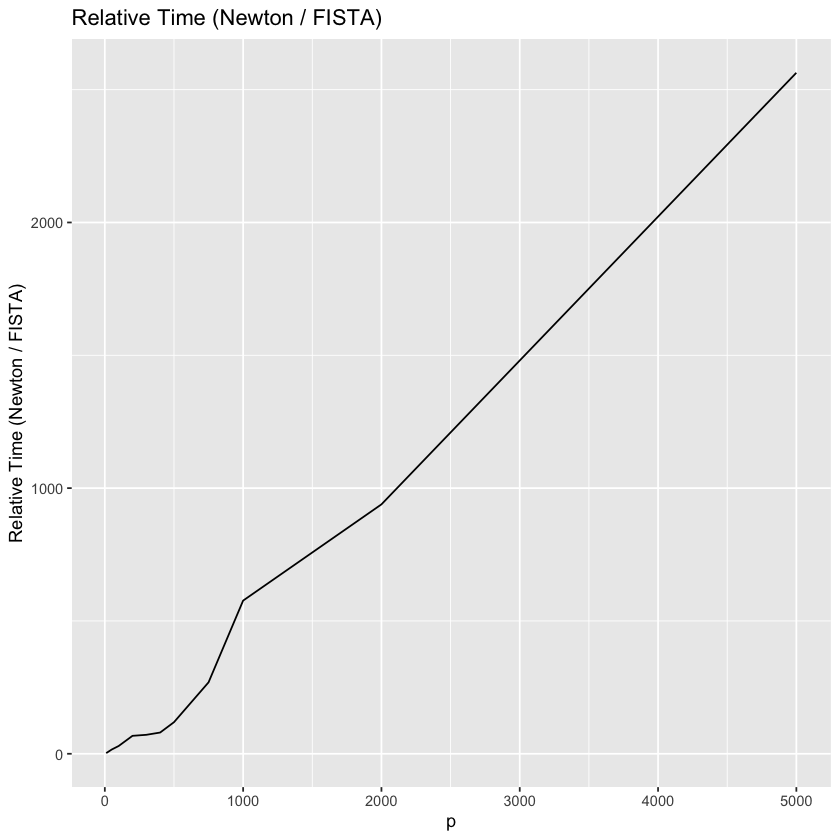

In [61]:
df.times <- data.frame(x=ps, y=bench.out$times[,2]/bench.out$times[,1])
times.plot <- ggplot(data=df.times, aes(x=x, y=y)) +
    geom_line() + 
    ggtitle("Relative Time (Newton / FISTA)") +
    xlab("p") +
    ylab("Relative Time (Newton / FISTA)")
times.plot

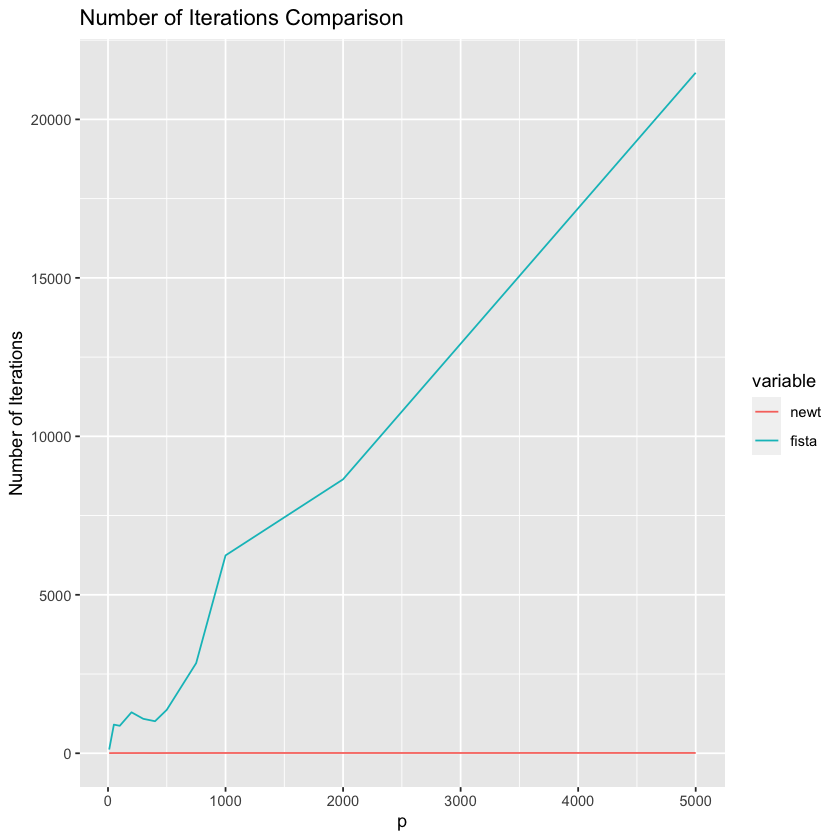

In [62]:
df.iters <- data.frame(x=ps, newt=bench.out$iters[,1], fista=bench.out$iters[,2])
df.iters <- melt(df.iters, id.vars='x')
iters.plot <- ggplot(data=df.iters, aes(x=x, y=value, color=variable)) +
    geom_line() +
    ggtitle("Number of Iterations Comparison") +
    xlab("p") +
    ylab("Number of Iterations")
iters.plot

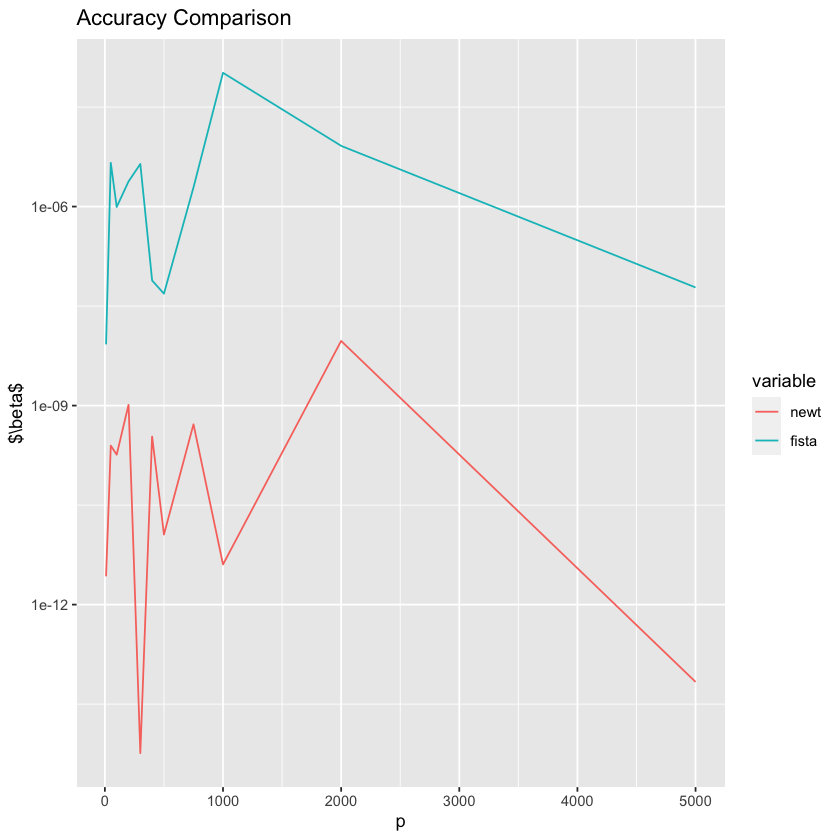

In [63]:
df.acc <- data.frame(x=ps, newt=bench.out$acc[,1], fista=bench.out$acc[,2])
df.acc <- melt(df.acc, id.vars='x')
acc.plot <- ggplot(data=df.acc, aes(x=x, y=value, color=variable)) +
    geom_line() +
    scale_y_log10() +
    ggtitle("Accuracy Comparison") +
    xlab("p") +
    ylab("$\\beta$")
acc.plot